# Imports

In [1]:
import numpy as np
import math
import schemdraw
import schemdraw.elements as elm
import random

# Genera Circuito

In [8]:
def dibujo_elemento(va):
  """
  Genera un número aleatorio entre 1 y 5 y devuelve un mensaje correspondiente.
  """
  numero_aleatorio = va
  if numero_aleatorio == 1:
    pass
  elif numero_aleatorio == 2:
    mensaje = elm.Line()
  elif numero_aleatorio == 3:
    mensaje = elm.Resistor()
  elif numero_aleatorio == 4:
    mensaje = elm.SourceV()
  else:  # numero_aleatorio == 5
    mensaje = elm.SourceI()

  return mensaje

# Ejemplo de uso:
#numero_aleatorio = random.randint(2, 5)
#mensaje_obtenido = obtener_mensaje_aleatorio(numero_aleatorio)
#print(mensaje_obtenido)

In [10]:
#para 1 malla
def generacircuito1malla(h,v):
    with schemdraw.Drawing() as d:
        d.config(unit=5)
        #izquierda vertical
        #x = dibujo_elemento(random.randint(2, 5))
        I1 = dibujo_elemento(v[0]).up()
        #I1 = elm.SourceV().label('20V')

        #superior horizontal
        HS = dibujo_elemento(h[0, 0]).right()
        #HS = elm.Resistor().right().label('400Ω')

        #derecha vertical
        D1 = dibujo_elemento(v[1]).down()
        #D1 = elm.SourceI().down().label('1A', loc='bot')

        #inferior horizontal
        #HI = elm.Line().left()
        HI = dibujo_elemento(h[1,0]).left().label('1A', loc='bot')
        #elm.Dot()
        #d.push()
        #R3 = elm.SourceI().down().label('100Ω', loc='bot', rotate=True)
        #R2 = elm.Resistor().down().label('100Ω', loc='bot', rotate=True)
        #elm.Dot()
        #d.pop()
        #I0 = elm.SourceV().right().label('1A', loc='bot')
        #L1 = elm.Line()
        #I1 = elm.SourceI().down().label('1A', loc='bot')
        #I1 = elm.Line().down()
        #L2 = elm.Line().tox(V1.start)
        #L2 = elm.Resistor().left().label('400Ω')
        #L3 = elm.Line().left()
        #elm.LoopCurrent([R1,R2,L2,V1], pad=1.25).label('$I_1$')
        #elm.LoopCurrent([R1,I1,L2,R2], pad=1.25).label('$I_2$')    # Use R1 as top element for both so they get the same height



In [11]:
#para 2 mallas
def generacircuito2mallas(h,v):
    with schemdraw.Drawing() as d:
        d.config(unit=5)
        V1 = dibujo_elemento(v[0]).up().label('20V')
        R1 = dibujo_elemento(h[0, 0]).right().label('400Ω')
        #elm.Dot()
        d.push()
        R3 = dibujo_elemento(v[1]).down().label('100Ω', loc='bot', rotate=True)
        #R2 = elm.Resistor().down().label('100Ω', loc='bot', rotate=True)
        #elm.Dot()
        d.pop()
        I0 = dibujo_elemento(h[0,1]).right().label('1A', loc='bot')
        #L1 = elm.Line()
        #I1 = elm.SourceI().down().label('1A', loc='bot')
        I1 = dibujo_elemento(v[2]).down()
        #L2 = elm.Line().tox(V1.start)
        L2 = dibujo_elemento(h[1,1]).left().label('400Ω')
        L3 = dibujo_elemento(h[1,0]).left()
        #elm.LoopCurrent([R1,R2,L2,V1], pad=1.25).label('$I_1$')
        #elm.LoopCurrent([R1,I1,L2,R2], pad=1.25).label('$I_2$')    # Use R1 as top element for both so they get the same height

# Funcion va

H:  [2 2]
V:  [[4]
 [3]]


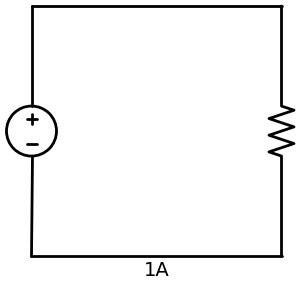

H:  [2 5 2 2]
V:  [[4]
 [3]
 [3]]


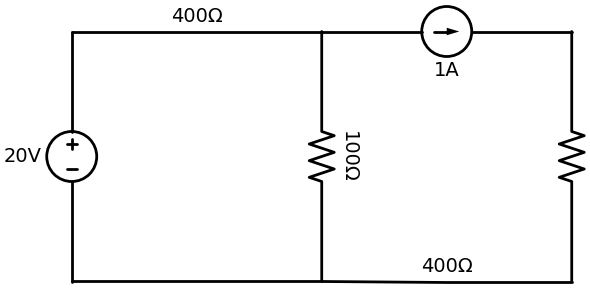

In [12]:

# Función equivalente a va(x, p, m, n) de MATLAB
def va(x, p, m, n):
    """
    Genera una matriz de m x n con elementos de x, siguiendo la distribución p.
    """
    return np.random.choice(x, size=(m, n), p=p)

# Ejemplo de prueba 1 malla
x = [2, 3, 4, 5]
p = [0.25, 0.25, 0.25, 0.25]
H = va(x, p, 2, 1)
V = va(x, p, 2, 1)

print("H: ",H.flatten())
print("V: ",V)


generacircuito1malla(H,V)

# Ejemplo de prueba 2 mallas
x = [2, 3, 4, 5]
p = [0.25, 0.25, 0.25, 0.25]
H = va(x, p, 2, 2)
V = va(x, p, 3, 1)

print("H: ",H.flatten())
print("V: ",V)

generacircuito2mallas(H,V)



# Actividad 1

In [6]:
# Simulación para la Actividad 1 (circuito de una malla)
# Evaluamos dos criterios de invalidez según las leyes de Kirchhoff

experimentos = 100_000
nocumple_corriente = 0
nocumple_24 = 0

for _ in range(experimentos):
    H = va(x, p, 1, 2)
    V = va(x, p, 1, 2)
    elementos = np.concatenate([H.flatten(), V.flatten()])

    # Criterio 1: más de una fuente de corriente (5)
    if np.sum(elementos == 5) > 1:
        nocumple_corriente += 1

    # Criterio 2: solo voltajes (4) y cortos (2), pero no todos cortos
    if np.all(np.isin(elementos, [2, 4])) and np.any(elementos == 4) and not np.all(elementos == 2):
        nocumple_24 += 1

# Resultados experimentales
fr_corriente = nocumple_corriente / experimentos
fr_24 = nocumple_24 / experimentos
fr_total = (nocumple_corriente + nocumple_24) / experimentos

# Resultados teóricos
total_combinaciones = 4**4  # 4 elementos, 4 opciones cada uno
# Combinaciones con 2 o más fuentes de corriente
inv_corriente = (
    (math.comb(4, 2) * 3**2) +  # 2 fuentes de corriente
    (math.comb(4, 3) * 3) +     # 3 fuentes de corriente
    1                              # 4 fuentes de corriente
)
teorico_corriente = inv_corriente / total_combinaciones

# Combinaciones con solo 2 y 4 (16 en total), excluyendo todos 2
teorico_24 = (2**4 - 1) / total_combinaciones
teorico_total = teorico_corriente + teorico_24

fr_corriente, fr_24, fr_total, teorico_corriente, teorico_24, teorico_total


(0.26287, 0.05827, 0.32114, 0.26171875, 0.05859375, 0.3203125)

# Actividad 2

In [209]:
# Simulación para la Actividad 2 (circuito de dos malla)
# Evaluamos tres criterios de invalidez según las leyes de Kirchhoff

import numpy as np
import math

# Simulación
experimentos = 1_000
inv_fuentes_seguidas = 0
inv_tres_corriente_medio = 0
inv_todas_resistencias = 0

for _ in range(experimentos):

    H = va(x, p, 1, 4).flatten()
    V = va(x, p, 1, 3).flatten()
    elementos = np.concatenate([H, V])
    
    malla_izq = [elementos[i] for i in [0, 2, 4, 5]]
    malla_der = [elementos[i] for i in [1, 3, 5, 6]]

    # Restricción 1: dos fuentes seguidas en la misma malla
    fuentes = [4, 5]
    if (elementos[0] in fuentes and elementos[4] in fuentes) or \
       (elementos[4] in fuentes and elementos[2] in fuentes) or \
       (elementos[1] in fuentes and elementos[6] in fuentes) or \
       (elementos[3] in fuentes and elementos[6] in fuentes) or \
       (elementos[5] in fuentes and elementos[0] in fuentes) or \
       (elementos[5] in fuentes and elementos[1] in fuentes) or \
       (elementos[5] in fuentes and elementos[2] in fuentes) or \
       (elementos[5] in fuentes and elementos[3] in fuentes):
          inv_fuentes_seguidas += 1
          continue

    # Restricción 2: tres fuentes de corriente en el medio
    if np.all(V == 5):
        inv_tres_corriente_medio += 1
        continue

    # Restricción 3: todos son resistencias (3)
    if np.all(elementos == 3):
        inv_todas_resistencias += 1
        continue

# Frecuencia experimental de casos inválidos
inv_total = inv_fuentes_seguidas + inv_tres_corriente_medio + inv_todas_resistencias
fr_inv = inv_total / experimentos
fr_valido = 1 - fr_inv

# Cálculo teórico
total_combinaciones = 4**7 

# Teórico: tres fuentes de corriente en el medio
inv_tres_corriente_medio_teo = 3**4 
# Teórico: solo resistencias
inv_todas_resistencias_teo = 1
# Teórico: dos fuentes seguidas en la misma malla  -- ----------------------------------------- 10110
inv_fuentes_sup = 4 * 4**5
inv_fuentes_inf = 4 * 4**5
# Intersección: fuentes en ambas mallas
interseccion = 4 * 4 * 4**3
inv_fuentes_seguidas_teo = inv_fuentes_sup + inv_fuentes_inf - interseccion

# Total inválidos teóricos
inv_total_teo = inv_tres_corriente_medio_teo + inv_todas_resistencias_teo + inv_fuentes_seguidas_teo
fr_valido_teo = (total_combinaciones - inv_total_teo) / total_combinaciones

# Resultados
print(f"FRECUENCIA EXPERIMENTAL:")
print(f"- Inválidos: {fr_inv:.5f}")
print(f"- Válidos:   {fr_valido:.5f}\n")

print(f"VALOR TEÓRICO:")
print(f"- Inválidos: {inv_total_teo} / {total_combinaciones} = {(inv_total_teo / total_combinaciones):.5f}")
print(f"- Válidos:   {fr_valido_teo:.5f}")

FRECUENCIA EXPERIMENTAL:
- Inválidos: 0.76500
- Válidos:   0.23500

VALOR TEÓRICO:
- Inválidos: 7250 / 16384 = 0.44250
- Válidos:   0.55750


# Actividad 3

## Probabilidad condicional 1 malla

In [258]:
def prob_condicional(elementos, x):
    p = np.ones(len(x), dtype=float)

    # Regla 1: máximo una fuente de corriente
    if np.sum(np.array(elementos) == 5) >= 1:
        p[np.array(x) == 5] = 0

    # Regla 2: evitar que el circuito se forme solo con fuentes de voltaje y cortos
    # pero permitir si todos son cortos
    if len(elementos) == 3:
        # solo hay cortos (2) y voltajes (4)
        if all(e in [2, 4] for e in elementos):
            # si no hay cortos, no permitir más voltajes o cortos
            if 2 not in elementos:
                # todos son voltajes (no permitido)
                p[np.isin(x, [2, 4])] = 0
            # si hay fuentes de voltaje y no hay resistencias
            elif 4 in elementos and 3 not in elementos:
                # hay mezcla de 2 y 4, pero sin resistencias: no permitir más 2 ni 4
                p[np.isin(x, [2, 4])] = 0

    p = p / np.sum(p)
    return p

## Generador circuito de una malla

In [260]:
def generar_malla_valida():
    x = [2, 3, 4, 5]
    H = np.zeros((2, 1), dtype=int)
    V = np.zeros((2, 1), dtype=int)
    elementos = []

    for i in range(4):
        p = prob_condicional(elementos, x)
        elegido = np.random.choice(x, p=p)
        elementos.append(elegido)
        if i < 2:
            H[i, 0] = elegido
        else:
            V[i - 2, 0] = elegido

    return H, V, elementos

[[4]
 [2]] [[5]
 [4]] [np.int64(4), np.int64(2), np.int64(5), np.int64(4)]


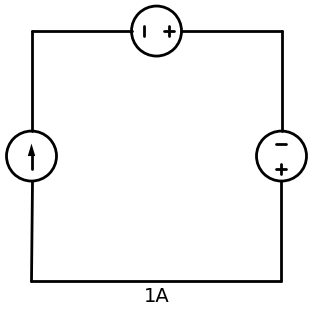

In [500]:
H, V, elementos_generados = generar_malla_valida()
print(H, V, elementos_generados)

generacircuito1malla(H, V)